In [171]:
### Import Packages
import os
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

### Read Files

In [172]:
### Read All files in a directory that contain "RESULTS" substring.

# Function to read all CSV files containing "RESULTS" in filename from a directory and its subdirectories
def read_csv_files(directory):
    all_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if "RESULTS" in file and file.endswith(".csv"):
                all_files.append(os.path.join(root, file))
    
    # Combine all CSV files into one DataFrame
    combined_df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)
    return combined_df

# Example usage
directory_path = './DATA/output/dataset1'
combined_df = read_csv_files(directory_path)


combined_df#.head()

,question,answer,contexts,ground_truth,model,context_precision,faithfulness,answer_relevancy,context_recall,answer_correctness,answer_similarity
0,What computational approach does PAL use to in...,PAL uses an approach that combines a large lan...,['PAL: Program-aided Language Models\nLuyu Gao...,PAL leverages large language models (LLMs) to ...,lucataco/qwen1.5-7b,1.0,1.000000,0.712241,1.000000,0.724417,0.897670
1,How does LLaMA's training data preprocessing a...,LLaMA's training data preprocessing and mixtur...,['LLaMA: Open and Efﬁcient Foundation Language...,LLaMA's training data includes a mixture of so...,lucataco/qwen1.5-7b,0.0,1.000000,1.000000,0.333333,0.510929,0.843718
2,In what way does Task2Vec's asymmetric distanc...,"Task2Vec's asymmetric distance, represented by...",['about the structure of the task. We may ther...,The asymmetric distance accounts for task comp...,lucataco/qwen1.5-7b,1.0,0.777778,0.792736,1.000000,0.169576,0.678304
3,How does Task2Vec ensure its task embeddings a...,Task2Vec ensures its task embeddings are invar...,['TASK2VEC: Task Embedding for Meta-Learning\n...,By basing the embeddings on the structure of t...,lucataco/qwen1.5-7b,1.0,1.000000,1.000000,1.000000,0.189867,0.759467
4,What role do random perturbations play in Dete...,Random perturbations are used in DetectGPT's m...,['Zero-Shot Machine-Generated Text Detection u...,Random perturbations are used to slightly modi...,lucataco/qwen1.5-7b,1.0,0.875000,0.931426,1.000000,0.393320,0.823280
...,...,...,...,...,...,...,...,...,...,...,...
1009,How do the LLaMA models' parameter counts comp...,The LLaMA models come in several different siz...,"['HellaSwag (Zellers et al., 2019), WinoGrande...",The LLaMA modelsvary in size from 7 billion pa...,01-ai/yi-34b-chat,0.0,0.285714,0.809094,1.000000,0.822851,0.891402
1010,What performance improvements does LLaMA-13B s...,"Based on the provided context, here's a summar...","['HellaSwag (Zellers et al., 2019), WinoGrande...",LLaMA-13B outperforms GPT-3 (175B) on most ben...,01-ai/yi-34b-chat,1.0,0.866667,0.651096,1.000000,0.403623,0.864490
1011,What specific challenges do the tasks in Super...,The tasks included in SuperGLUE aim to challen...,['Public data: We require that tasks have exis...,"The tasks challenge models on various fronts, ...",01-ai/yi-34b-chat,1.0,0.666667,0.702388,0.000000,0.165375,0.661501
1012,What contributions does CodeNet make towards t...,"Based on the information provided, Codenet mak...",['CodeNet: A Large-Scale AI for Code Dataset f...,By providing a comprehensive dataset with div...,01-ai/yi-34b-chat,1.0,0.666667,0.956133,1.000000,0.222002,0.888009


In [173]:
combined_df['contexts'] = combined_df['contexts'].apply(eval)
combined_df['concatenated_contexts'] = combined_df['contexts'].apply(lambda x: ' '.join(x))

In [136]:
#combined_df["ground_truth"]

In [174]:
len(combined_df)

1014

In [175]:
len(combined_df.dropna())

918

### Drop no-answer rows

In [177]:
combined_df = combined_df.dropna()

### Calculate BLEU, BLEU_Score and ROUGUE_Score

In [178]:
# %pip install rouge
# %pip install bert_score

In [179]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
from bert_score import score

# Assuming your dataframe is named 'df'

# Function to calculate BLEU score
def calculate_bleu(reference, candidate):
    smoothie = SmoothingFunction().method1
    return sentence_bleu([reference.split()], candidate.split(),
                        weights=(0.25, 0.25, 0.25, 0.25),  # This gives equal weight to 1, 2, 3, and 4-grams
                        smoothing_function=smoothie
                        )

# Function to calculate ROUGE scores
def calculate_rouge(reference, candidate):
    rouge = Rouge()
    scores = rouge.get_scores(candidate, reference)
    return scores[0]['rouge-l']['f']  # Using ROUGE-L F1 score


def calculate_bertscore(references, candidates):
    P, R, F1 = score(candidates, references, lang="en", verbose=False)
    return F1.tolist()  # Return F1 scores as a list

# Apply the functions to create new columns
combined_df['BLEUScore'] = combined_df.apply(lambda row: calculate_bleu(row['ground_truth'], row['answer']), axis=1)
combined_df['ROUGEScore'] = combined_df.apply(lambda row: calculate_rouge(row['ground_truth'], row['answer']), axis=1)

# Calculate BERTScore
references = combined_df['ground_truth'].tolist()
candidates = combined_df['answer'].tolist()
combined_df['BERTScore'] = calculate_bertscore(references, candidates)


# If you want separate columns for different BLEU scores (e.g., BLEU-1, BLEU-2, etc.),
# you can modify the calculate_bleu function and add more columns accordingly.

# Display the updated dataframe
#combined_df.head()

/tmp/ipykernel_3766653/3913079309.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['BLEUScore'] = combined_df.apply(lambda row: calculate_bleu(row['ground_truth'], row['answer']), axis=1)
/tmp/ipykernel_3766653/3913079309.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['ROUGEScore'] = combined_df.apply(lambda row: calculate_rouge(row['ground_truth'], row['answer']), axis=1)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are n

In [230]:
combined_df.to_csv("./DATA/output/dataset1/metricsBertBleuRouge.csv", encoding='utf-8', index=False)

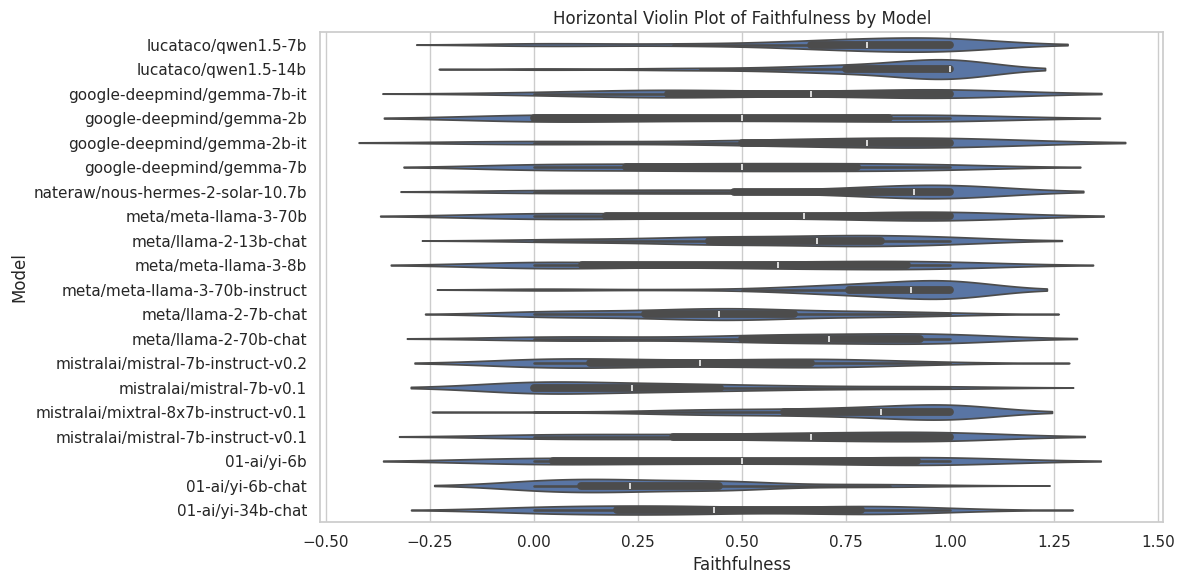

In [182]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming combined_df is already available from the previous steps

# Plot horizontal violin plot for faithfulness for each model
plt.figure(figsize=(12, 6))
sns.violinplot(y='model', x='faithfulness', data=combined_df)
plt.title('Horizontal Violin Plot of Faithfulness by Model')
plt.ylabel('Model')
plt.xlabel('Faithfulness')
plt.tight_layout()
plt.show()


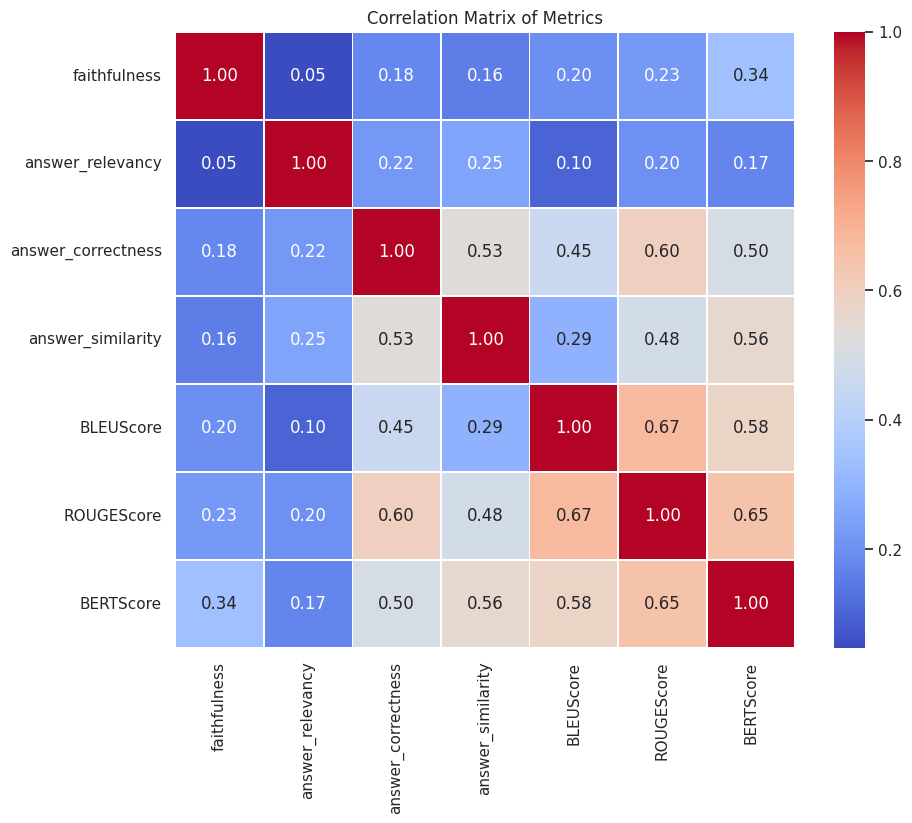

In [183]:
corr_matrix = combined_df[['faithfulness', 'answer_relevancy', 'answer_correctness', 'answer_similarity','BLEUScore', 'ROUGEScore', 'BERTScore']].corr()

# Plotting the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Metrics')
plt.show()

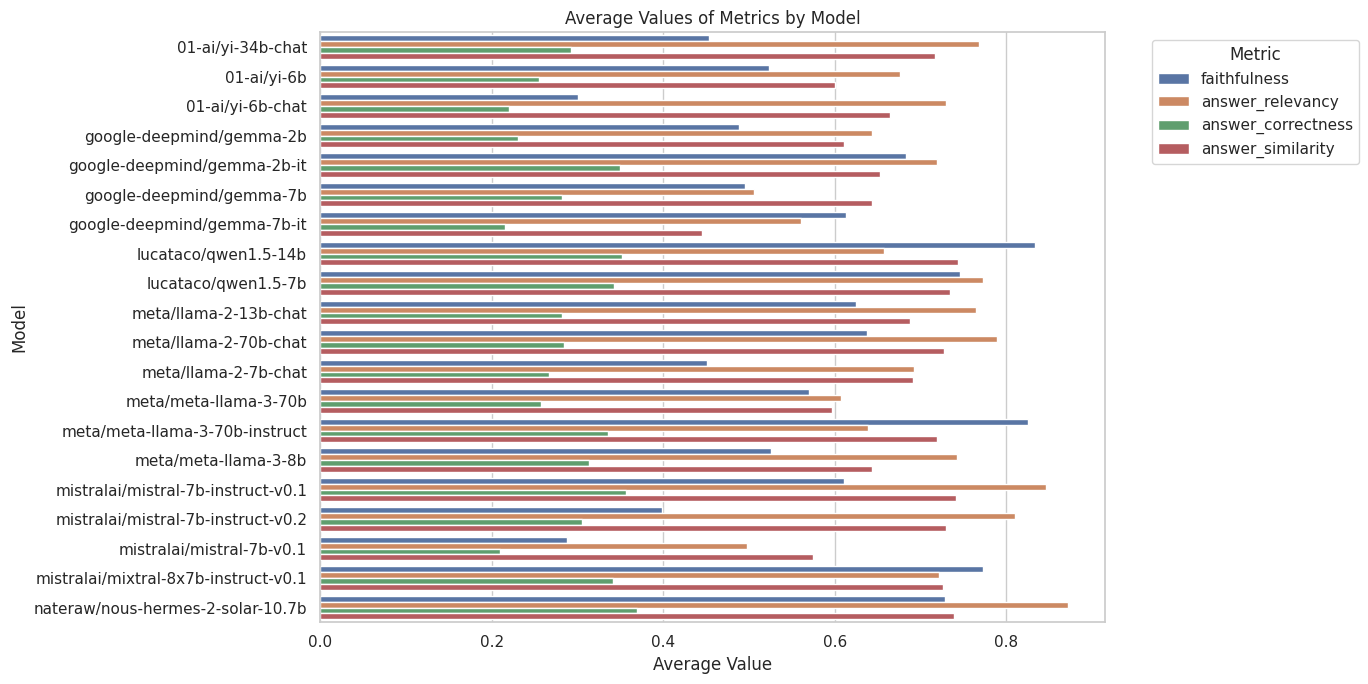

In [184]:
# Calculate average values for the specified columns
average_df = combined_df.groupby('model')[['faithfulness', 'answer_relevancy', 'answer_correctness', 'answer_similarity']].mean().reset_index()

# Melt the DataFrame for easier plotting with seaborn
melted_df = average_df.melt(id_vars='model', var_name='metric', value_name='average_value')

# Plot barplot
plt.figure(figsize=(14, 7))
sns.barplot(x='average_value', y='model', hue='metric', data=melted_df)
plt.title('Average Values of Metrics by Model')
plt.xlabel('Average Value')
plt.ylabel('Model')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

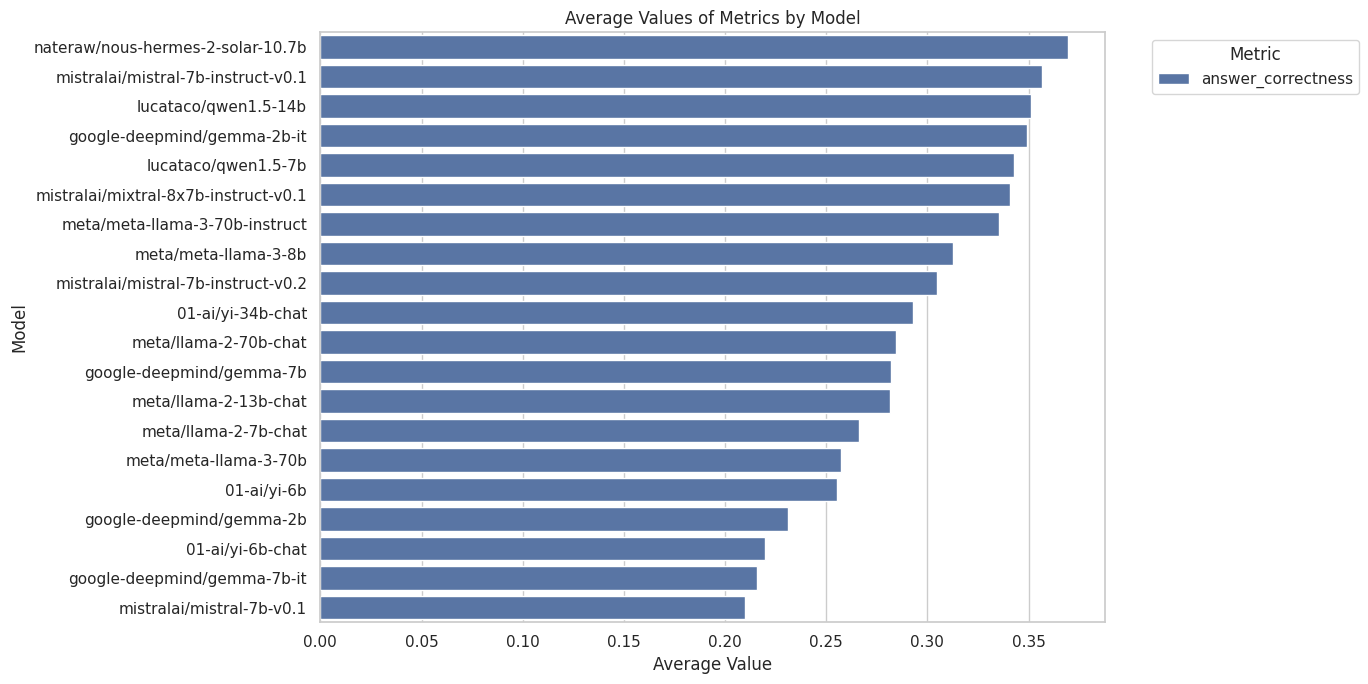

In [185]:
# Calculate average values for the specified columns
average_df = combined_df.groupby('model')[['answer_correctness']].mean().reset_index()
average_df = average_df.sort_values(by='answer_correctness', ascending=False)

# Melt the DataFrame for easier plotting with seaborn
melted_df = average_df.melt(id_vars='model', var_name='metric', value_name='average_value')

# Plot barplot
plt.figure(figsize=(14, 7))
sns.barplot(x='average_value', y='model', hue='metric', data=melted_df)
plt.title('Average Values of Metrics by Model')
plt.xlabel('Average Value')
plt.ylabel('Model')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

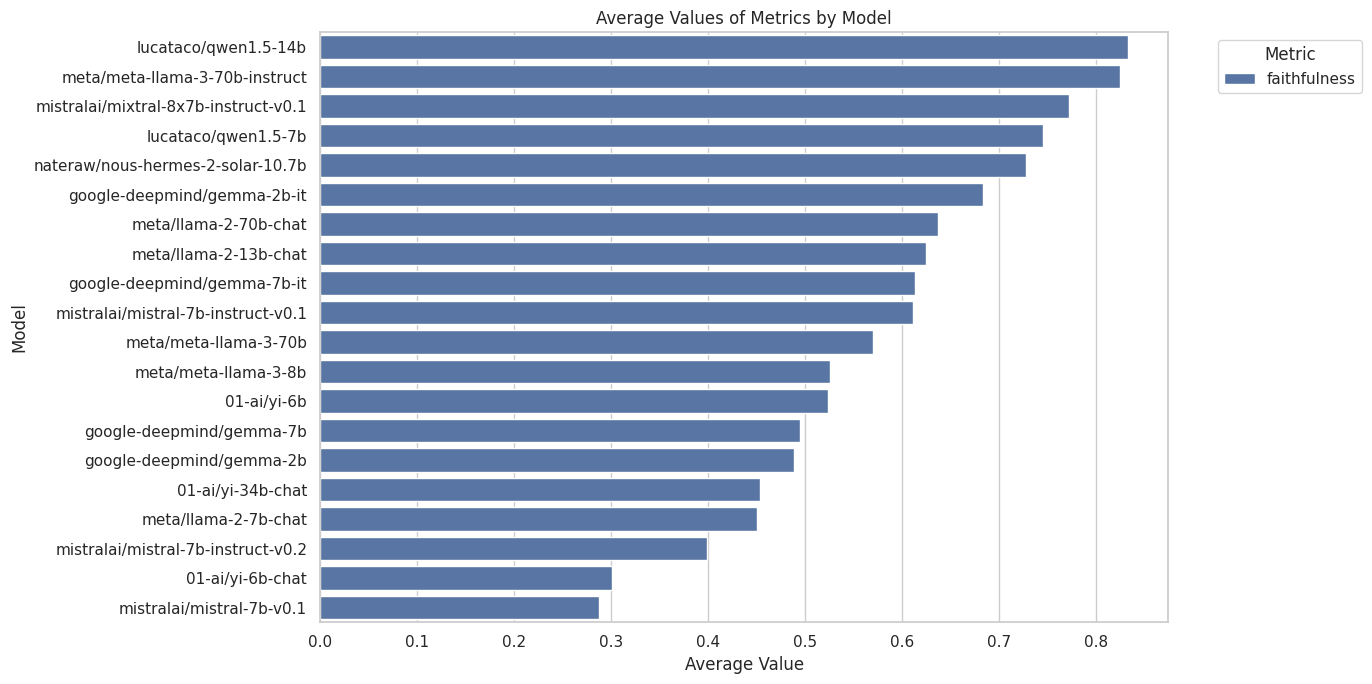

In [229]:
# Calculate average values for the specified columns
average_df = combined_df.groupby('model')[['faithfulness']].mean().reset_index()
average_df = average_df.sort_values(by='faithfulness', ascending=False)

# Melt the DataFrame for easier plotting with seaborn
melted_df = average_df.melt(id_vars='model', var_name='metric', value_name='average_value')

# Plot barplot
plt.figure(figsize=(14, 7))
sns.barplot(x='average_value', y='model', hue='metric', data=melted_df)
plt.title('Average Values of Metrics by Model')
plt.xlabel('Average Value')
plt.ylabel('Model')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

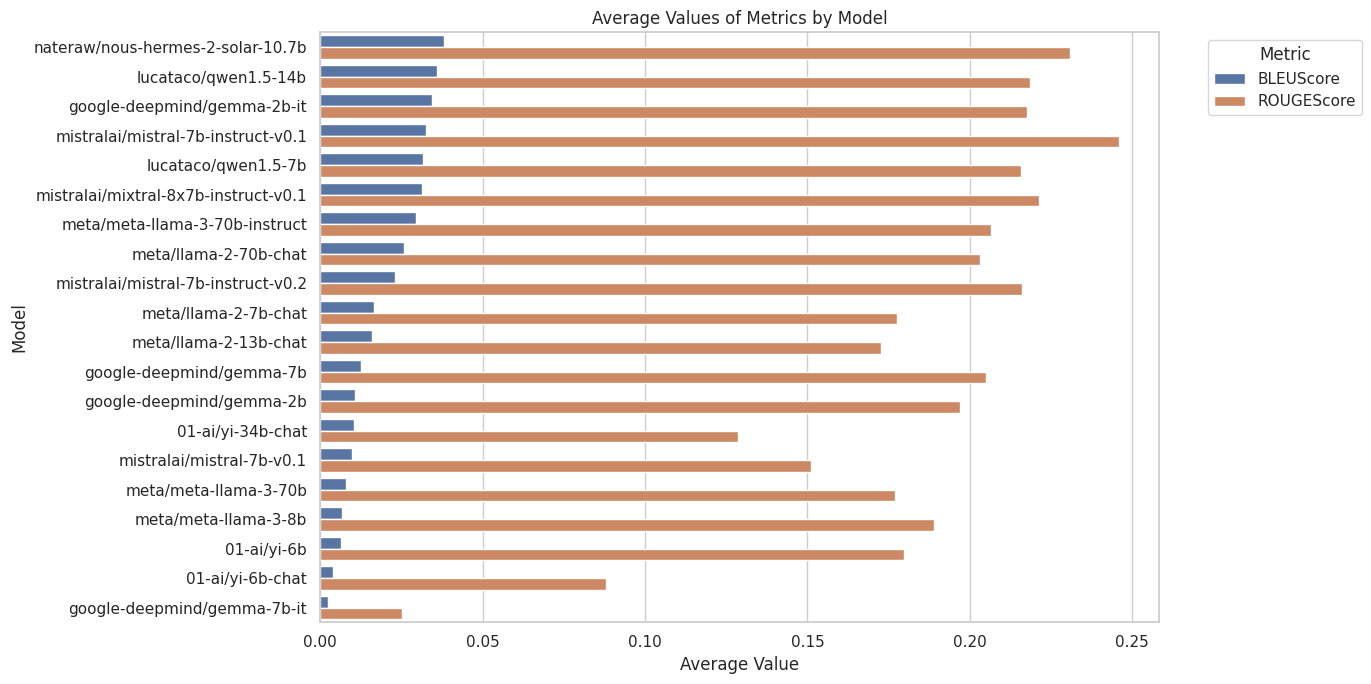

In [186]:
# Calculate average values for the specified columns
average_df = combined_df.groupby('model')[['BLEUScore', 'ROUGEScore']].mean().reset_index()
average_df = average_df.sort_values(by='BLEUScore', ascending=False)

# Melt the DataFrame for easier plotting with seaborn
melted_df = average_df.melt(id_vars='model', var_name='metric', value_name='average_value')

# Plot barplot
plt.figure(figsize=(14, 7))
sns.barplot(x='average_value', y='model', hue='metric', data=melted_df)
plt.title('Average Values of Metrics by Model')
plt.xlabel('Average Value')
plt.ylabel('Model')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

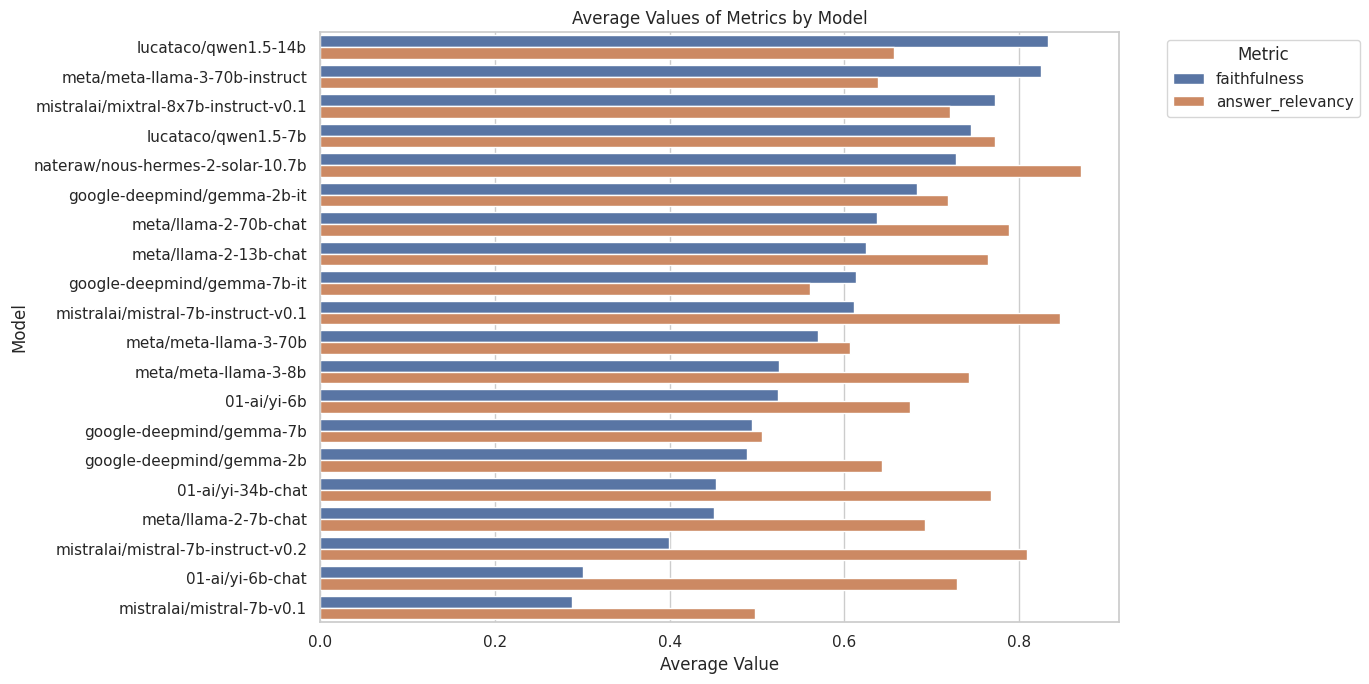

In [187]:
# Calculate average values for the specified columns
average_df = combined_df.groupby('model')[["faithfulness", "answer_relevancy"]].mean().reset_index()
average_df = average_df.sort_values(by='faithfulness', ascending=False)

# Melt the DataFrame for easier plotting with seaborn
melted_df = average_df.melt(id_vars='model', var_name='metric', value_name='average_value')

# Plot barplot
plt.figure(figsize=(14, 7))
sns.barplot(x='average_value', y='model', hue='metric', data=melted_df)
plt.title('Average Values of Metrics by Model')
plt.xlabel('Average Value')
plt.ylabel('Model')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

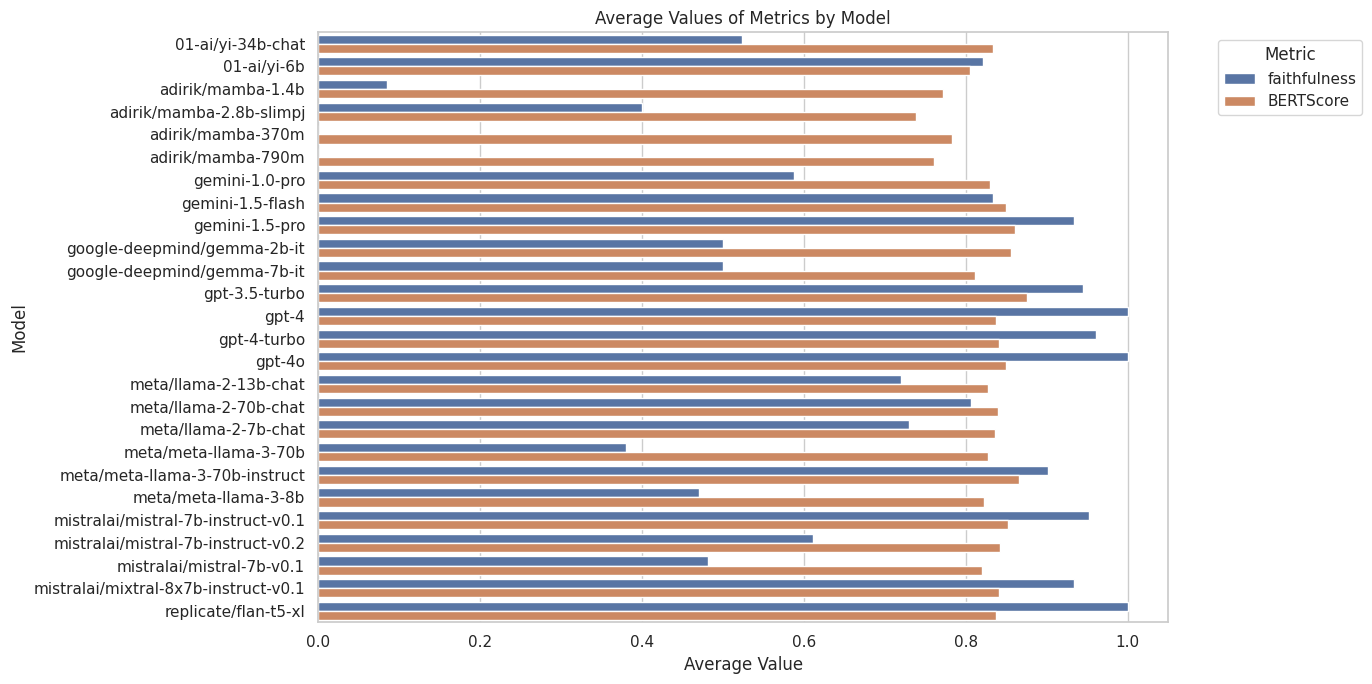

In [162]:
# Calculate average values for the specified columns
average_df = combined_df.groupby('model')[["faithfulness", 'BERTScore']].mean().reset_index()

# Melt the DataFrame for easier plotting with seaborn
melted_df = average_df.melt(id_vars='model', var_name='metric', value_name='average_value')

# Plot barplot
plt.figure(figsize=(14, 7))
sns.barplot(x='average_value', y='model', hue='metric', data=melted_df)
plt.title('Average Values of Metrics by Model')
plt.xlabel('Average Value')
plt.ylabel('Model')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

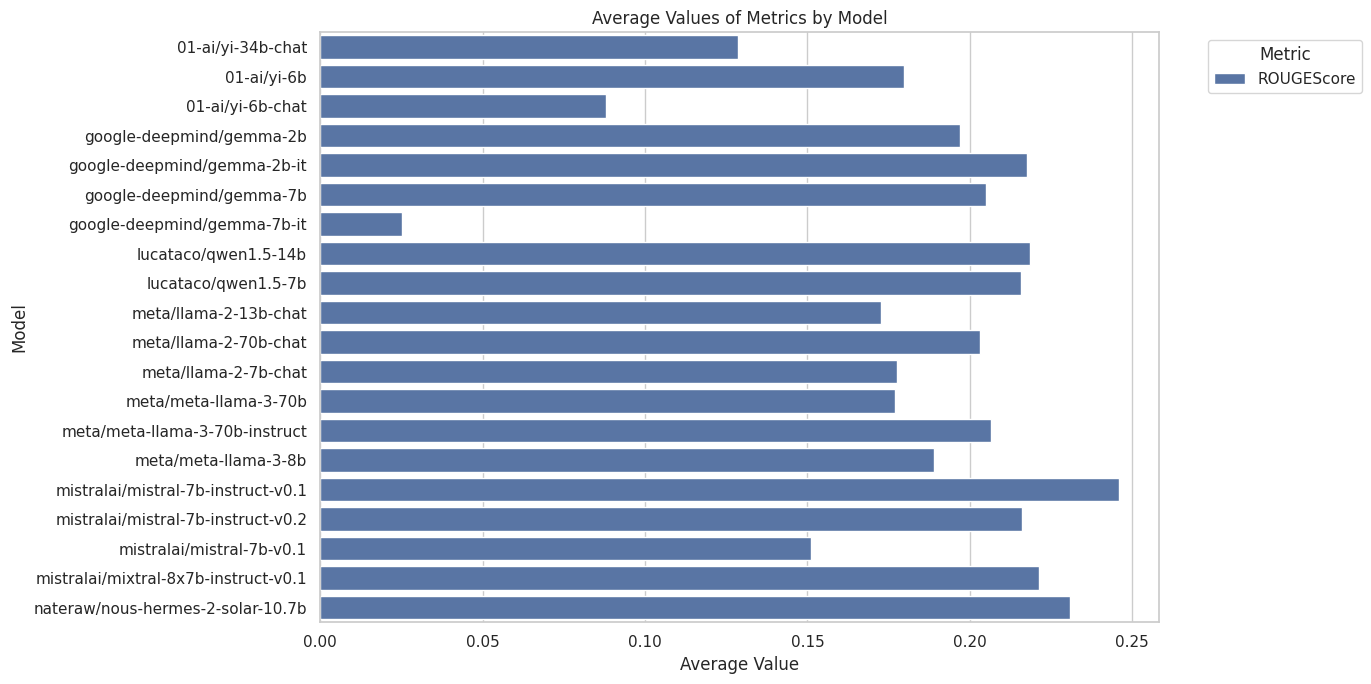

In [188]:
# Calculate average values for the specified columns
average_df = combined_df.groupby('model')[['ROUGEScore']].mean().reset_index()

# Melt the DataFrame for easier plotting with seaborn
melted_df = average_df.melt(id_vars='model', var_name='metric', value_name='average_value')

# Plot barplot
plt.figure(figsize=(14, 7))
sns.barplot(x='average_value', y='model', hue='metric', data=melted_df)
plt.title('Average Values of Metrics by Model')
plt.xlabel('Average Value')
plt.ylabel('Model')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

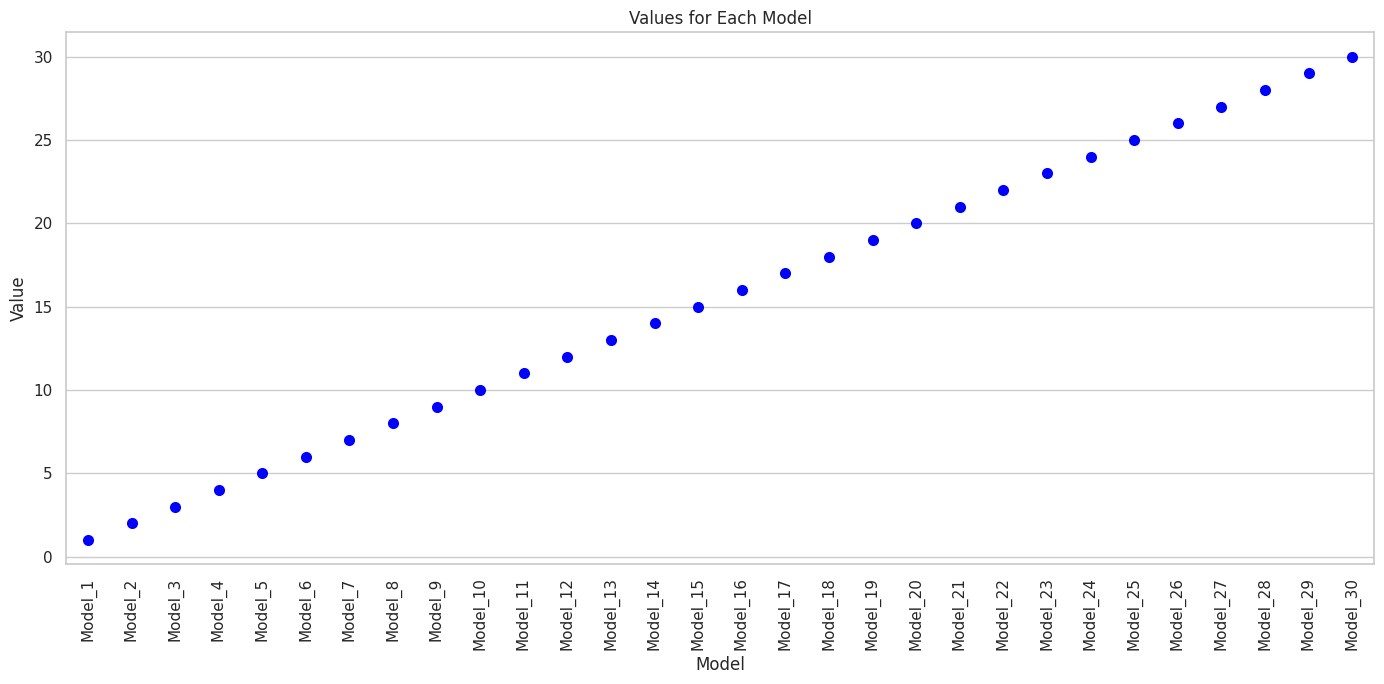

In [189]:
# Sample data creation for demonstration
data = {
    'model': [f'Model_{i}' for i in range(1, 31)],
    'value': [i for i in range(1, 31)]  # Replace with your actual values
}

df = pd.DataFrame(data)

# Plot vertical dot plot
plt.figure(figsize=(14, 7))
sns.stripplot(x='model', y='value', data=df, size=8, color='blue', jitter=False)
plt.title('Values for Each Model')
plt.xlabel('Model')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [190]:
combined_df

,question,answer,contexts,ground_truth,model,context_precision,faithfulness,answer_relevancy,context_recall,answer_correctness,answer_similarity,concatenated_contexts,BLEUScore,ROUGEScore,BERTScore
0,What computational approach does PAL use to in...,PAL uses an approach that combines a large lan...,[PAL: Program-aided Language Models\nLuyu Gao*...,PAL leverages large language models (LLMs) to ...,lucataco/qwen1.5-7b,1.0,1.000000,0.712241,1.000000,0.724417,0.897670,PAL: Program-aided Language Models\nLuyu Gao* ...,0.059525,0.320988,0.912698
1,How does LLaMA's training data preprocessing a...,LLaMA's training data preprocessing and mixtur...,[LLaMA: Open and Efﬁcient Foundation Language ...,LLaMA's training data includes a mixture of so...,lucataco/qwen1.5-7b,0.0,1.000000,1.000000,0.333333,0.510929,0.843718,LLaMA: Open and Efﬁcient Foundation Language M...,0.022909,0.243902,0.853357
2,In what way does Task2Vec's asymmetric distanc...,"Task2Vec's asymmetric distance, represented by...",[about the structure of the task. We may there...,The asymmetric distance accounts for task comp...,lucataco/qwen1.5-7b,1.0,0.777778,0.792736,1.000000,0.169576,0.678304,about the structure of the task. We may theref...,0.003070,0.164948,0.854169
3,How does Task2Vec ensure its task embeddings a...,Task2Vec ensures its task embeddings are invar...,[TASK2VEC: Task Embedding for Meta-Learning\nA...,By basing the embeddings on the structure of t...,lucataco/qwen1.5-7b,1.0,1.000000,1.000000,1.000000,0.189867,0.759467,TASK2VEC: Task Embedding for Meta-Learning\nAl...,0.011786,0.222222,0.885922
4,What role do random perturbations play in Dete...,Random perturbations are used in DetectGPT's m...,[Zero-Shot Machine-Generated Text Detection us...,Random perturbations are used to slightly modi...,lucataco/qwen1.5-7b,1.0,0.875000,0.931426,1.000000,0.393320,0.823280,Zero-Shot Machine-Generated Text Detection usi...,0.033141,0.257426,0.880344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,How do the LLaMA models' parameter counts comp...,The LLaMA models come in several different siz...,"[HellaSwag (Zellers et al., 2019), WinoGrande ...",The LLaMA modelsvary in size from 7 billion pa...,01-ai/yi-34b-chat,0.0,0.285714,0.809094,1.000000,0.822851,0.891402,"HellaSwag (Zellers et al., 2019), WinoGrande (...",0.006911,0.188406,0.847468
1010,What performance improvements does LLaMA-13B s...,"Based on the provided context, here's a summar...","[HellaSwag (Zellers et al., 2019), WinoGrande ...",LLaMA-13B outperforms GPT-3 (175B) on most ben...,01-ai/yi-34b-chat,1.0,0.866667,0.651096,1.000000,0.403623,0.864490,"HellaSwag (Zellers et al., 2019), WinoGrande (...",0.009220,0.178771,0.848814
1011,What specific challenges do the tasks in Super...,The tasks included in SuperGLUE aim to challen...,[Public data: We require that tasks have exist...,"The tasks challenge models on various fronts, ...",01-ai/yi-34b-chat,1.0,0.666667,0.702388,0.000000,0.165375,0.661501,Public data: We require that tasks have existi...,0.002779,0.103704,0.826570
1012,What contributions does CodeNet make towards t...,"Based on the information provided, Codenet mak...",[CodeNet: A Large-Scale AI for Code Dataset fo...,By providing a comprehensive dataset with div...,01-ai/yi-34b-chat,1.0,0.666667,0.956133,1.000000,0.222002,0.888009,CodeNet: A Large-Scale AI for Code Dataset for...,0.016094,0.129310,0.854749


In [191]:
combined_df.groupby('model')[['faithfulness', 'answer_relevancy', 'answer_correctness', 'answer_similarity']].mean()

,faithfulness,answer_relevancy,answer_correctness,answer_similarity
model,,,,
01-ai/yi-34b-chat,0.453202,0.768168,0.292709,0.717085
01-ai/yi-6b,0.523716,0.675393,0.255079,0.600136
01-ai/yi-6b-chat,0.300463,0.729144,0.219637,0.664692
google-deepmind/gemma-2b,0.488684,0.643115,0.230968,0.610144
google-deepmind/gemma-2b-it,0.683333,0.718868,0.349150,0.652813
google-deepmind/gemma-7b,0.494819,0.505826,0.281832,0.643422
google-deepmind/gemma-7b-it,0.613412,0.560273,0.215567,0.445517
lucataco/qwen1.5-14b,0.832944,0.657092,0.351177,0.743944
lucataco/qwen1.5-7b,0.745280,0.772580,0.342635,0.734182


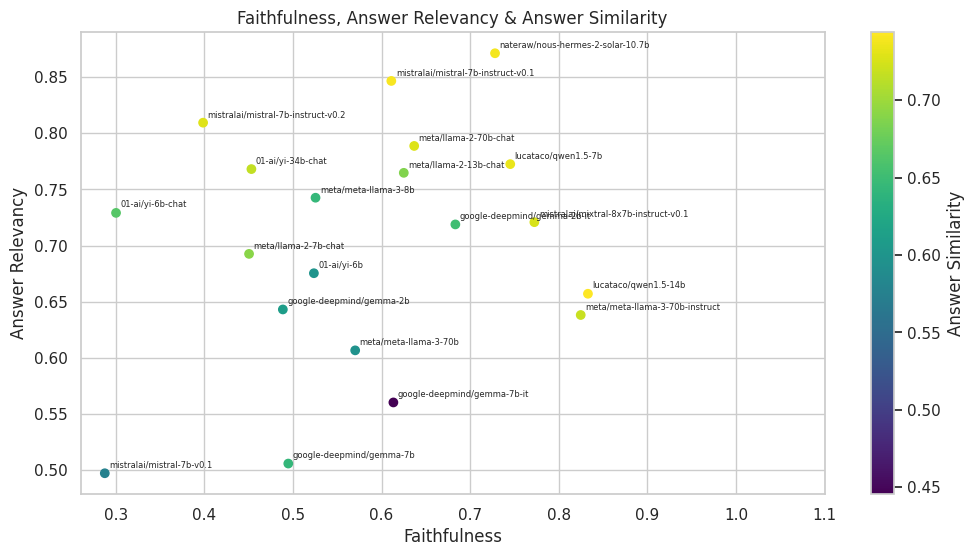

In [192]:
grouped_df = combined_df.groupby('model')[['faithfulness', 'answer_relevancy', 'answer_correctness', 'answer_similarity']].mean()
grouped_df["llm_name"] = grouped_df.index

# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter('faithfulness', 'answer_relevancy', c='answer_similarity', cmap='viridis', data=grouped_df)

# Add text labels with a slight offset
offset = 0.005  # Adjust offset value as needed to prevent overlap
for index, row in grouped_df.iterrows():
    ax.text(row['faithfulness'] + offset, row['answer_relevancy'] + offset, row['llm_name'], fontsize=6)

# Set axis labels
ax.set_xlabel('Faithfulness')
ax.set_ylabel('Answer Relevancy')
ax.set_xlim(right=1.1)  # Extend the x-axis limit for better visibility
ax.set_title('Faithfulness, Answer Relevancy & Answer Similarity')

# Create and label the color bar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Answer Similarity')  # Set color bar label



plt.savefig("Faithfulness-vs-Answer-Relevancy-vs-Answer-Similarity.png")
plt.savefig("Faithfulness-vs-Answer-Relevancy-vs-Answer-Similarity.pdf")
# Show plot
plt.show()

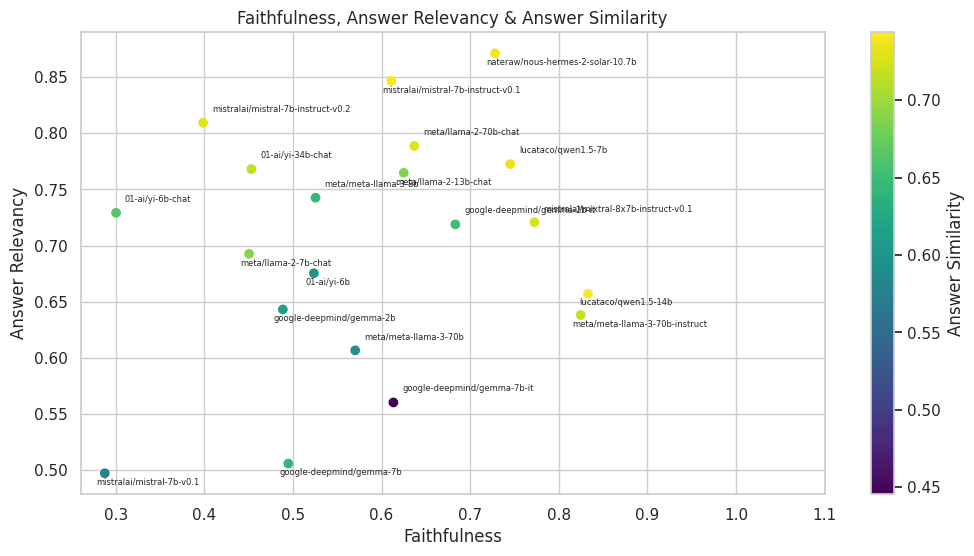

In [193]:
grouped_df = combined_df.groupby('model')[['faithfulness', 'answer_relevancy', 'answer_correctness', 'answer_similarity']].mean()
grouped_df["llm_name"] = grouped_df.index

# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter('faithfulness', 'answer_relevancy', c='answer_similarity', cmap='viridis', data=grouped_df)

# Adjust text labels with a slight offset based on index
offset = 0.01  # Adjust offset value as needed to prevent overlap
for i, (index, row) in enumerate(grouped_df.iterrows()):
    # Alternate offsets for better visibility
    if i % 2 == 0:
        ax.text(row['faithfulness'] + offset, row['answer_relevancy'] + offset, row['llm_name'], fontsize=6)
    else:
        ax.text(row['faithfulness'] - offset, row['answer_relevancy'] - offset, row['llm_name'], fontsize=6)

# Set axis labels
ax.set_xlabel('Faithfulness')
ax.set_ylabel('Answer Relevancy')
ax.set_xlim(right=1.1)  # Extend the x-axis limit for better visibility
ax.set_title('Faithfulness, Answer Relevancy & Answer Similarity')

# Create and label the color bar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Answer Similarity')  # Set color bar label

#plt.savefig("/mnt/data/Faithfulness-vs-Answer-Relevancy-vs-Answer-Similarity.png")
#plt.savefig("/mnt/data/Faithfulness-vs-Answer-Relevancy-vs-Answer-Similarity.pdf")
# Show plot
plt.show()

In [194]:
### Extract Metrics
df_metrics1 = combined_df.groupby('model')[['faithfulness', 'answer_relevancy', 'answer_correctness', 'answer_similarity', 'BLEUScore', 'ROUGEScore',	'BERTScore']].mean()
df_metrics1

,faithfulness,answer_relevancy,answer_correctness,answer_similarity,BLEUScore,ROUGEScore,BERTScore
model,,,,,,,
01-ai/yi-34b-chat,0.453202,0.768168,0.292709,0.717085,0.010215,0.128498,0.842237
01-ai/yi-6b,0.523716,0.675393,0.255079,0.600136,0.006239,0.179643,0.809785
01-ai/yi-6b-chat,0.300463,0.729144,0.219637,0.664692,0.003981,0.088050,0.832940
google-deepmind/gemma-2b,0.488684,0.643115,0.230968,0.610144,0.010580,0.196961,0.833679
google-deepmind/gemma-2b-it,0.683333,0.718868,0.349150,0.652813,0.034342,0.217721,0.872908
google-deepmind/gemma-7b,0.494819,0.505826,0.281832,0.643422,0.012604,0.204989,0.842483
google-deepmind/gemma-7b-it,0.613412,0.560273,0.215567,0.445517,0.002206,0.025067,0.815060
lucataco/qwen1.5-14b,0.832944,0.657092,0.351177,0.743944,0.036008,0.218652,0.874564
lucataco/qwen1.5-7b,0.745280,0.772580,0.342635,0.734182,0.031571,0.215841,0.872814


In [195]:
df_metrics1["Model"] = df_metrics1.index
df_metrics1[['provider','Model']] = df_metrics1['Model'].str.split('/',expand=True)
#df_metrics1.index = df_metrics1["model"]
df_metrics1

,faithfulness,answer_relevancy,answer_correctness,answer_similarity,BLEUScore,ROUGEScore,BERTScore,Model,provider
model,,,,,,,,,
01-ai/yi-34b-chat,0.453202,0.768168,0.292709,0.717085,0.010215,0.128498,0.842237,yi-34b-chat,01-ai
01-ai/yi-6b,0.523716,0.675393,0.255079,0.600136,0.006239,0.179643,0.809785,yi-6b,01-ai
01-ai/yi-6b-chat,0.300463,0.729144,0.219637,0.664692,0.003981,0.088050,0.832940,yi-6b-chat,01-ai
google-deepmind/gemma-2b,0.488684,0.643115,0.230968,0.610144,0.010580,0.196961,0.833679,gemma-2b,google-deepmind
google-deepmind/gemma-2b-it,0.683333,0.718868,0.349150,0.652813,0.034342,0.217721,0.872908,gemma-2b-it,google-deepmind
google-deepmind/gemma-7b,0.494819,0.505826,0.281832,0.643422,0.012604,0.204989,0.842483,gemma-7b,google-deepmind
google-deepmind/gemma-7b-it,0.613412,0.560273,0.215567,0.445517,0.002206,0.025067,0.815060,gemma-7b-it,google-deepmind
lucataco/qwen1.5-14b,0.832944,0.657092,0.351177,0.743944,0.036008,0.218652,0.874564,qwen1.5-14b,lucataco
lucataco/qwen1.5-7b,0.745280,0.772580,0.342635,0.734182,0.031571,0.215841,0.872814,qwen1.5-7b,lucataco


### Load Benchmark Metrics

In [196]:
df_llm_metrics = pd.read_csv('/home/hamzicd/DS/Paper1-RAGG/impl/LLMs-Overview-Paper-Sheet4.csv')

In [197]:
df_llm_metrics

,Raw model,Model,Unnamed: 2,Average ⬆️,IFEval,BBH,MATH Lvl 5,GPQA,MUSR,MMLU-PRO,Type
0,"0: {model: 'meta-llama-3-70b-instruct', runs: ...",meta-llama-3-70b-instruct,NaN,36.18,80.99,50.19,23.34,4.92,10.92,46.74,"💬 chat models (RLHF, DPO, IFT, ...)"
1,"1: {model: 'meta-llama-3-8b', runs: 48900000}",meta-llama-3-8b,NaN,13.41,14.55,24.50,3.25,7.38,6.24,24.55,🟢 pretrained
2,"2: {model: 'meta-llama-3-8b-instruct', runs: 3...",meta-llama-3-8b-instruct,NaN,23.91,74.08,28.24,8.69,1.23,1.60,29.60,"💬 chat models (RLHF, DPO, IFT, ...)"
3,"3: {model: 'mixtral-8x7b-instruct-v0.1', runs:...",mixtral-8x7b-instruct-v0.1,NaN,24.35,53.95,34.02,9.06,7.61,12.11,29.36,"💬 chat models (RLHF, DPO, IFT, ...)"
4,"4: {model: 'llama-2-7b-chat', runs: 8400000}",llama-2-7b-chat,NaN,9.40,39.65,4.49,0.68,0.56,3.48,7.52,"💬 chat models (RLHF, DPO, IFT, ...)"
5,"5: {model: 'llama-2-70b-chat', runs: 7400000}",llama-2-70b-chat,NaN,12.73,49.58,4.61,0.91,1.90,3.48,15.92,"💬 chat models (RLHF, DPO, IFT, ...)"
6,"6: {model: 'llama-2-13b-chat', runs: 4400000}",llama-2-13b-chat,NaN,11.00,39.85,7.16,0.60,0.00,8.16,10.26,"💬 chat models (RLHF, DPO, IFT, ...)"
7,"7: {model: 'mistral-7b-instruct-v0.2', runs: 2...",mistral-7b-instruct-v0.2,NaN,18.44,54.96,22.91,2.64,3.47,7.61,19.08,"💬 chat models (RLHF, DPO, IFT, ...)"
8,"8: {model: 'mistral-7b-v0.1', runs: 1700000}",mistral-7b-v0.1,NaN,14.50,23.86,22.02,2.49,5.59,10.68,22.36,🟢 pretrained
9,"9: {model: 'mistral-7b-instruct-v0.1', runs: 9...",mistral-7b-instruct-v0.1,NaN,13.57,45.02,13.79,1.51,0.00,5.77,15.34,"💬 chat models (RLHF, DPO, IFT, ...)"


In [198]:
df_metrics_combined = pd.merge(df_llm_metrics, df_metrics1, on='Model')#.corr()
df_metrics_combined.index = df_metrics_combined.Model
df_metrics_combined.drop(columns=['Raw model', 'Unnamed: 2', 'provider', "Model"], inplace=True)

In [199]:
df_metrics_combined

,Average ⬆️,IFEval,BBH,MATH Lvl 5,GPQA,MUSR,MMLU-PRO,Type,faithfulness,answer_relevancy,answer_correctness,answer_similarity,BLEUScore,ROUGEScore,BERTScore
Model,,,,,,,,,,,,,,,
meta-llama-3-70b-instruct,36.18,80.99,50.19,23.34,4.92,10.92,46.74,"💬 chat models (RLHF, DPO, IFT, ...)",0.824787,0.638173,0.335544,0.719353,0.029565,0.206598,0.865319
meta-llama-3-8b,13.41,14.55,24.50,3.25,7.38,6.24,24.55,🟢 pretrained,0.525547,0.742660,0.312806,0.643773,0.006804,0.189125,0.816647
mixtral-8x7b-instruct-v0.1,24.35,53.95,34.02,9.06,7.61,12.11,29.36,"💬 chat models (RLHF, DPO, IFT, ...)",0.772481,0.720865,0.340653,0.725717,0.031268,0.221390,0.865982
llama-2-7b-chat,9.40,39.65,4.49,0.68,0.56,3.48,7.52,"💬 chat models (RLHF, DPO, IFT, ...)",0.450554,0.692618,0.266349,0.690632,0.016475,0.177686,0.848803
llama-2-70b-chat,12.73,49.58,4.61,0.91,1.90,3.48,15.92,"💬 chat models (RLHF, DPO, IFT, ...)",0.636885,0.788779,0.284663,0.727702,0.025667,0.203140,0.858527
llama-2-13b-chat,11.00,39.85,7.16,0.60,0.00,8.16,10.26,"💬 chat models (RLHF, DPO, IFT, ...)",0.625145,0.764821,0.281698,0.687847,0.015889,0.172563,0.847309
mistral-7b-instruct-v0.2,18.44,54.96,22.91,2.64,3.47,7.61,19.08,"💬 chat models (RLHF, DPO, IFT, ...)",0.398690,0.809504,0.304772,0.729020,0.022889,0.215947,0.861542
mistral-7b-v0.1,14.50,23.86,22.02,2.49,5.59,10.68,22.36,🟢 pretrained,0.287762,0.497191,0.209844,0.575025,0.009834,0.151064,0.840959
mistral-7b-instruct-v0.1,13.57,45.02,13.79,1.51,0.00,5.77,15.34,"💬 chat models (RLHF, DPO, IFT, ...)",0.611079,0.846696,0.356650,0.740715,0.032449,0.245859,0.873249


In [200]:
df_metrics_combined_corr = pd.get_dummies(df_metrics_combined).corr()
df_metrics_combined_corr

,Average ⬆️,IFEval,BBH,MATH Lvl 5,GPQA,MUSR,MMLU-PRO,faithfulness,answer_relevancy,answer_correctness,answer_similarity,BLEUScore,ROUGEScore,BERTScore,"Type_💬 chat models (RLHF, DPO, IFT, ...)",Type_🟢 pretrained
Average ⬆️,1.000000,0.571837,0.938072,0.835369,0.570597,0.627796,0.926703,0.392836,-0.002851,0.343403,0.307466,0.252535,0.140814,0.177024,0.105591,-0.105591
IFEval,0.571837,1.000000,0.277908,0.292967,-0.219450,0.049252,0.311910,0.346380,0.355799,0.370714,0.467593,0.448737,0.138571,0.492262,0.735111,-0.735111
BBH,0.938072,0.277908,1.000000,0.814559,0.745262,0.706692,0.950548,0.286490,-0.087167,0.283516,0.188777,0.120456,0.127753,0.016169,-0.156744,0.156744
MATH Lvl 5,0.835369,0.292967,0.814559,1.000000,0.501910,0.598733,0.795662,0.535365,-0.272236,0.311942,0.194620,0.275739,0.239422,0.162695,-0.196204,0.196204
GPQA,0.570597,-0.219450,0.745262,0.501910,1.000000,0.584571,0.691029,0.016798,-0.196460,-0.022307,-0.119825,-0.195916,-0.158882,-0.285343,-0.274334,0.274334
MUSR,0.627796,0.049252,0.706692,0.598733,0.584571,1.000000,0.552640,0.310775,-0.355669,0.043971,-0.220574,0.012341,-0.044823,-0.111390,-0.277690,0.277690
MMLU-PRO,0.926703,0.311910,0.950548,0.795662,0.691029,0.552640,1.000000,0.238989,-0.063908,0.246819,0.277145,0.091879,0.123090,0.010592,-0.142376,0.142376
faithfulness,0.392836,0.346380,0.286490,0.535365,0.016798,0.310775,0.238989,1.000000,0.224994,0.729252,0.361997,0.718981,0.442098,0.529170,0.104054,-0.104054
answer_relevancy,-0.002851,0.355799,-0.087167,-0.272236,-0.196460,-0.355669,-0.063908,0.224994,1.000000,0.589486,0.691878,0.497546,0.395707,0.467809,0.507516,-0.507516
answer_correctness,0.343403,0.370714,0.283516,0.311942,-0.022307,0.043971,0.246819,0.729252,0.589486,1.000000,0.746305,0.880327,0.745411,0.770010,0.209121,-0.209121


/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128994 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128172 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/hamzicd/.local/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128994 missing from current font.
  font.set_text(s, 0, flags=flags)


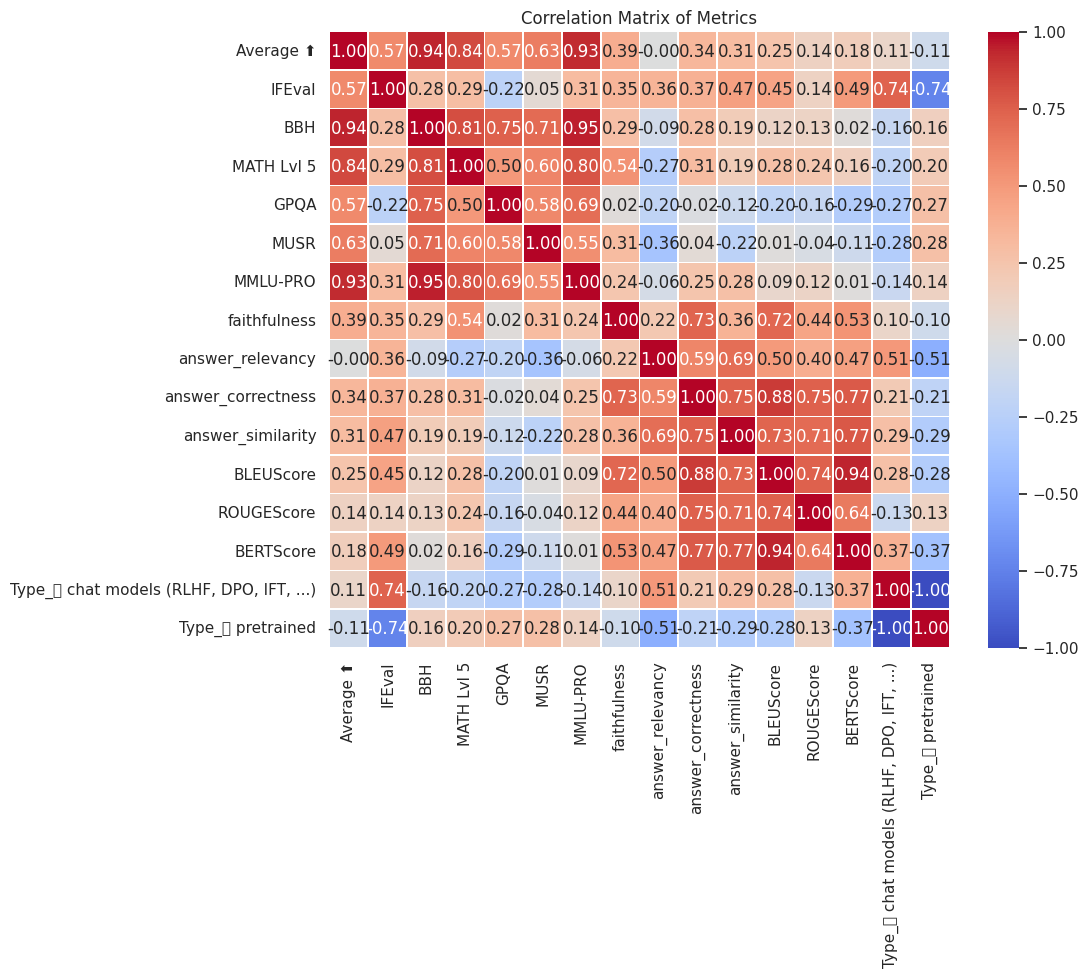

In [201]:
# Plotting the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(df_metrics_combined_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Metrics')
plt.show()

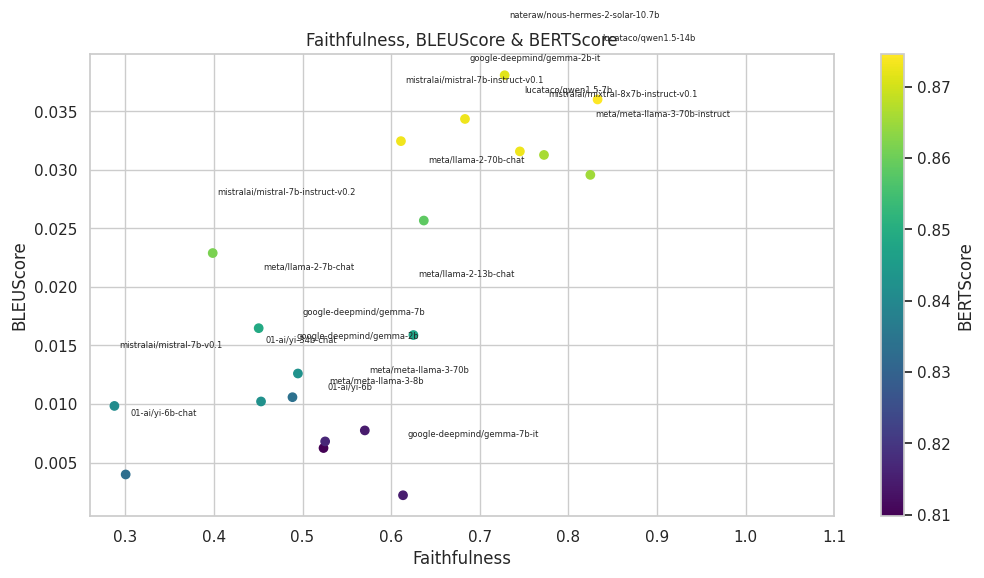

In [209]:
grouped_df = combined_df.groupby('model')[['faithfulness', 'answer_relevancy', 'answer_correctness', 'answer_similarity', 'BLEUScore', 'BERTScore']].mean()
grouped_df["llm_name"] = grouped_df.index

# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 6))
sc = ax.scatter('faithfulness', 'BLEUScore', c='BERTScore', cmap='viridis', data=grouped_df)

# Add text labels with a slight offset
offset = 0.005  # Adjust offset value as needed to prevent overlap
for index, row in grouped_df.iterrows():
    ax.text(row['faithfulness'] + offset, row['BLEUScore'] + offset, row['llm_name'], fontsize=6)

# Set axis labels
ax.set_xlabel('Faithfulness')
ax.set_ylabel('BLEUScore')
ax.set_xlim(right=1.1)  # Extend the x-axis limit for better visibility
ax.set_title('Faithfulness, BLEUScore & BERTScore')

# Create and label the color bar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('BERTScore')  # Set color bar label



#plt.savefig("Faithfulness-vs-Answer-Relevancy-vs-Answer-Similarity.png")
#plt.savefig("Faithfulness-vs-Answer-Relevancy-vs-Answer-Similarity.pdf")
# Show plot
plt.show()

In [210]:
grouped_df

,faithfulness,answer_relevancy,answer_correctness,answer_similarity,BLEUScore,BERTScore,llm_name
model,,,,,,,
01-ai/yi-34b-chat,0.453202,0.768168,0.292709,0.717085,0.010215,0.842237,01-ai/yi-34b-chat
01-ai/yi-6b,0.523716,0.675393,0.255079,0.600136,0.006239,0.809785,01-ai/yi-6b
01-ai/yi-6b-chat,0.300463,0.729144,0.219637,0.664692,0.003981,0.832940,01-ai/yi-6b-chat
google-deepmind/gemma-2b,0.488684,0.643115,0.230968,0.610144,0.010580,0.833679,google-deepmind/gemma-2b
google-deepmind/gemma-2b-it,0.683333,0.718868,0.349150,0.652813,0.034342,0.872908,google-deepmind/gemma-2b-it
google-deepmind/gemma-7b,0.494819,0.505826,0.281832,0.643422,0.012604,0.842483,google-deepmind/gemma-7b
google-deepmind/gemma-7b-it,0.613412,0.560273,0.215567,0.445517,0.002206,0.815060,google-deepmind/gemma-7b-it
lucataco/qwen1.5-14b,0.832944,0.657092,0.351177,0.743944,0.036008,0.874564,lucataco/qwen1.5-14b
lucataco/qwen1.5-7b,0.745280,0.772580,0.342635,0.734182,0.031571,0.872814,lucataco/qwen1.5-7b


In [214]:
df_metrics_combined.head()

,Average ⬆️,IFEval,BBH,MATH Lvl 5,GPQA,MUSR,MMLU-PRO,Type,faithfulness,answer_relevancy,answer_correctness,answer_similarity,BLEUScore,ROUGEScore,BERTScore
Model,,,,,,,,,,,,,,,
meta-llama-3-70b-instruct,36.18,80.99,50.19,23.34,4.92,10.92,46.74,"💬 chat models (RLHF, DPO, IFT, ...)",0.824787,0.638173,0.335544,0.719353,0.029565,0.206598,0.865319
meta-llama-3-8b,13.41,14.55,24.50,3.25,7.38,6.24,24.55,🟢 pretrained,0.525547,0.742660,0.312806,0.643773,0.006804,0.189125,0.816647
mixtral-8x7b-instruct-v0.1,24.35,53.95,34.02,9.06,7.61,12.11,29.36,"💬 chat models (RLHF, DPO, IFT, ...)",0.772481,0.720865,0.340653,0.725717,0.031268,0.221390,0.865982
llama-2-7b-chat,9.40,39.65,4.49,0.68,0.56,3.48,7.52,"💬 chat models (RLHF, DPO, IFT, ...)",0.450554,0.692618,0.266349,0.690632,0.016475,0.177686,0.848803
llama-2-70b-chat,12.73,49.58,4.61,0.91,1.90,3.48,15.92,"💬 chat models (RLHF, DPO, IFT, ...)",0.636885,0.788779,0.284663,0.727702,0.025667,0.203140,0.858527


In [222]:
X = df_metrics_combined[['IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO']]
# 'answer_relevancy', 'answer_correctness', 'answer_similarity', 'BLEUScore','ROUGEScore', 'BERTScore'
#y = df_metrics_combined['faithfulness']
y = df_metrics_combined['faithfulness']

In [223]:
import statsmodels.api as sm
# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           faithfulness   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     1.763
Date:                Thu, 25 Jul 2024   Prob (F-statistic):              0.184
Time:                        09:42:35   Log-Likelihood:                 14.886
No. Observations:                  20   AIC:                            -15.77
Df Residuals:                      13   BIC:                            -8.802
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4914      0.151      3.251      0.0

In [228]:

for metric in ['faithfulness','answer_relevancy', 'answer_correctness', 'answer_similarity', 'BLEUScore','ROUGEScore', 'BERTScore']:
    y = df_metrics_combined[metric]
    
    X = sm.add_constant(X)
    
    # Fit the linear regression model
    model = sm.OLS(y, X).fit()
    
    # Print the summary of the regression model
    print(metric)
    print(model.summary())

faithfulness
                            OLS Regression Results                            
Dep. Variable:           faithfulness   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     1.763
Date:                Thu, 25 Jul 2024   Prob (F-statistic):              0.184
Time:                        09:47:06   Log-Likelihood:                 14.886
No. Observations:                  20   AIC:                            -15.77
Df Residuals:                      13   BIC:                            -8.802
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4914      0.151      3